Trajectories for k = 1.00 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_1.00.npy
Trajectories for k = 1.10 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_1.10.npy
Trajectories for k = 1.20 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_1.20.npy
Trajectories for k = 1.30 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_1.30.npy
Trajectories for k = 1.40 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_1.40.npy
Trajectories for k = 1.50 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_1.50.npy
Trajectories for k = 1.60 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_1.60.npy
Trajectories for k = 1.70 saved to

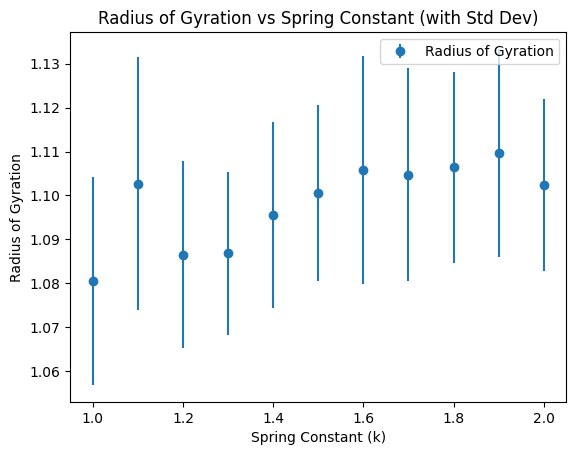

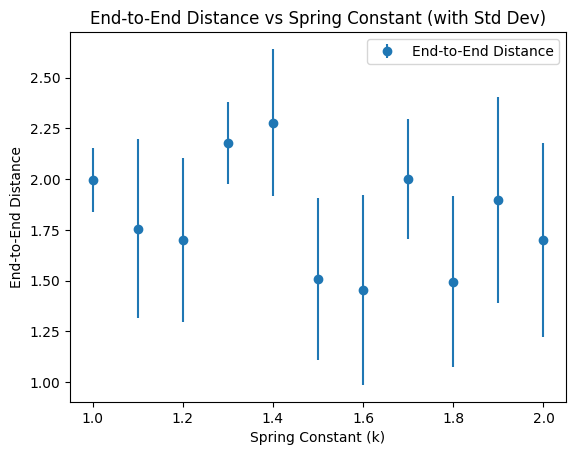

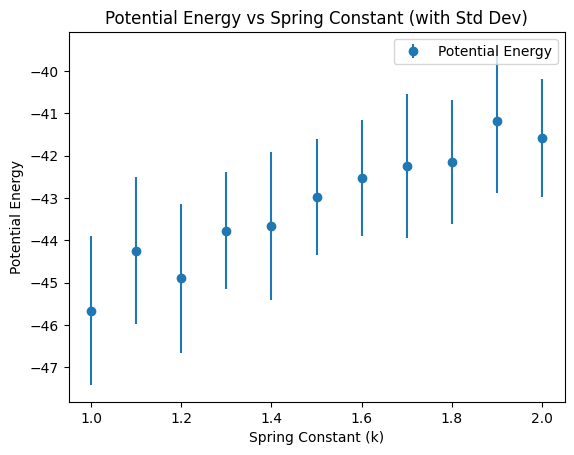

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 50000  # Number of steps (20,000 in total)
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.1  # Target temperature (fixed)
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.43  # Depth of repulsive LJ potential (fixed)
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Arrays to store results for different k values
k_values = np.linspace(1.0, 2.0, 11)
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

for k in k_values:
    # Re-initialize positions and velocities for each k value
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties during each step after 50,000 steps
    Rg_values = []
    Ree_values = []
    potential_energies = []

    # Run simulation loop
    for step in range(total_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store values only after step 40,000
        if step >= 40000:
            # Compute properties for this step
            Rg = calculate_radius_of_gyration(positions)
            Ree = calculate_end_to_end_distance(positions)

            # Calculate potential energy
            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2

            E_LJ = 0.0
            for i in range(n_particles - 1):
                for j in range(i + 1, n_particles):
                    displacement = positions[j] - positions[i]
                    displacement = minimum_image(displacement, box_size)
                    distance = np.linalg.norm(displacement)
                    if distance < cutoff:
                        if abs(i - j) == 2:
                            epsilon_value = epsilon_repulsive
                        elif abs(i - j) > 2:
                            epsilon_value = epsilon_attractive
                        else:
                            continue
                        E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

            potential_energy = E_harmonic + E_LJ

            # Store values
            Rg_values.append(Rg)
            Ree_values.append(Ree)
            potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)

    # Calculate mean and standard deviation for each property after step 10,000
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with error bars
plt.figure()
plt.errorbar(k_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Spring Constant (k)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()


In [2]:
# Print results for Radius of Gyration
print("Spring Constant (k) vs Radius of Gyration")
print(f"{'Spring Constant (k)':>20} {'Mean Rg':>10} {'Std Rg':>10}")
for k, mean_Rg, std_Rg in zip(k_values, mean_Rg_values, std_Rg_values):
    print(f"{k:20.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nSpring Constant (k) vs End-to-End Distance")
print(f"{'Spring Constant (k)':>20} {'Mean Ree':>10} {'Std Ree':>10}")
for k, mean_Ree, std_Ree in zip(k_values, mean_Ree_values, std_Ree_values):
    print(f"{k:20.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nSpring Constant (k) vs Potential Energy")
print(f"{'Spring Constant (k)':>20} {'Mean PE':>10} {'Std PE':>10}")
for k, mean_PE, std_PE in zip(k_values, mean_potential_energies, std_potential_energies):
    print(f"{k:20.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Spring Constant (k) vs Radius of Gyration
 Spring Constant (k)    Mean Rg     Std Rg
              1.0000     1.0806     0.0237
              1.1000     1.1027     0.0288
              1.2000     1.0865     0.0213
              1.3000     1.0868     0.0186
              1.4000     1.0955     0.0212
              1.5000     1.1005     0.0200
              1.6000     1.1057     0.0260
              1.7000     1.1048     0.0242
              1.8000     1.1065     0.0218
              1.9000     1.1097     0.0237
              2.0000     1.1024     0.0196

Spring Constant (k) vs End-to-End Distance
 Spring Constant (k)   Mean Ree    Std Ree
              1.0000     1.9964     0.1575
              1.1000     1.7557     0.4401
              1.2000     1.7004     0.4037
              1.3000     2.1782     0.2020
              1.4000     2.2780     0.3632
              1.5000     1.5077     0.3973
              1.6000     1.4530     0.4672
              1.7000     2.0004     0.2955
           

Trajectories for k = 2.00 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_2.00.npy
Trajectories for k = 2.10 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_2.10.npy
Trajectories for k = 2.20 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_2.20.npy
Trajectories for k = 2.30 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_2.30.npy
Trajectories for k = 2.40 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_2.40.npy
Trajectories for k = 2.50 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_2.50.npy
Trajectories for k = 2.60 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_2.60.npy
Trajectories for k = 2.70 saved to

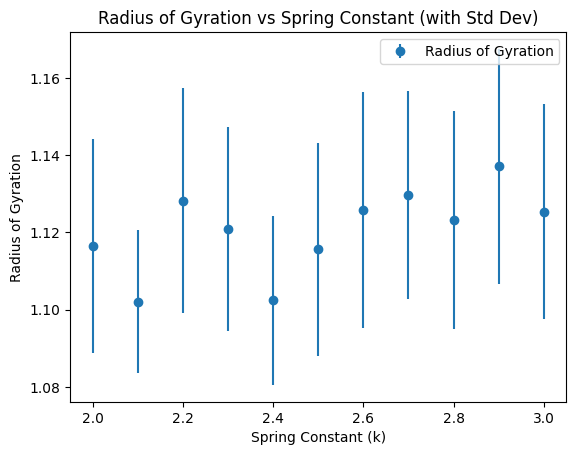

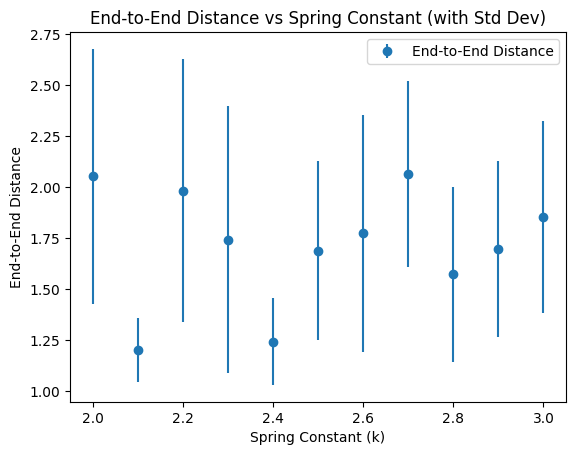

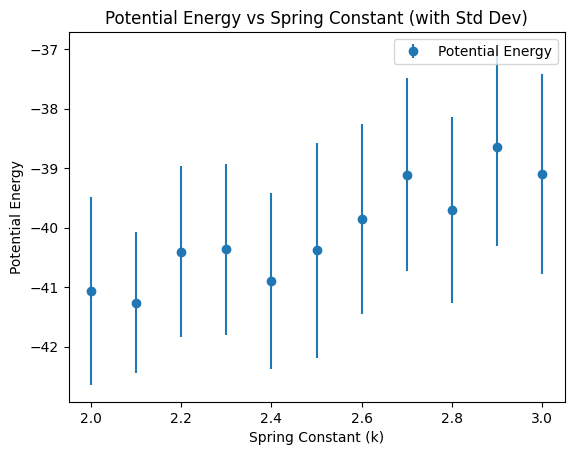

In [3]:
# Spring constant range for the simulation
k_values = np.linspace(2.0, 3.0, 11)

# Arrays to store results for different k values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each spring constant k
for k in k_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, k)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, k)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(len(positions) - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current k value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_k_{k:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for k = {k:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current k value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(k_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Spring Constant (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Spring Constant (k)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Spring Constant (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Spring Constant (with Std Dev)')
plt.legend()
plt.show()


In [4]:
# Print results for Radius of Gyration
print("Spring Constant (k) vs Radius of Gyration")
print(f"{'Spring Constant (k)':>20} {'Mean Rg':>10} {'Std Rg':>10}")
for k, mean_Rg, std_Rg in zip(k_values, mean_Rg_values, std_Rg_values):
    print(f"{k:20.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nSpring Constant (k) vs End-to-End Distance")
print(f"{'Spring Constant (k)':>20} {'Mean Ree':>10} {'Std Ree':>10}")
for k, mean_Ree, std_Ree in zip(k_values, mean_Ree_values, std_Ree_values):
    print(f"{k:20.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nSpring Constant (k) vs Potential Energy")
print(f"{'Spring Constant (k)':>20} {'Mean PE':>10} {'Std PE':>10}")
for k, mean_PE, std_PE in zip(k_values, mean_potential_energies, std_potential_energies):
    print(f"{k:20.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Spring Constant (k) vs Radius of Gyration
 Spring Constant (k)    Mean Rg     Std Rg
              2.0000     1.1164     0.0277
              2.1000     1.1021     0.0185
              2.2000     1.1282     0.0291
              2.3000     1.1208     0.0264
              2.4000     1.1024     0.0219
              2.5000     1.1156     0.0277
              2.6000     1.1258     0.0305
              2.7000     1.1297     0.0268
              2.8000     1.1231     0.0282
              2.9000     1.1371     0.0304
              3.0000     1.1254     0.0278

Spring Constant (k) vs End-to-End Distance
 Spring Constant (k)   Mean Ree    Std Ree
              2.0000     2.0533     0.6232
              2.1000     1.2037     0.1562
              2.2000     1.9833     0.6447
              2.3000     1.7426     0.6532
              2.4000     1.2444     0.2125
              2.5000     1.6885     0.4391
              2.6000     1.7731     0.5818
              2.7000     2.0651     0.4541
           

Trajectories for k = 3.00 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_3.00.npy
Trajectories for k = 3.10 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_3.10.npy
Trajectories for k = 3.20 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_3.20.npy
Trajectories for k = 3.30 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_3.30.npy
Trajectories for k = 3.40 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_3.40.npy
Trajectories for k = 3.50 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_3.50.npy
Trajectories for k = 3.60 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_3.60.npy
Trajectories for k = 3.70 saved to

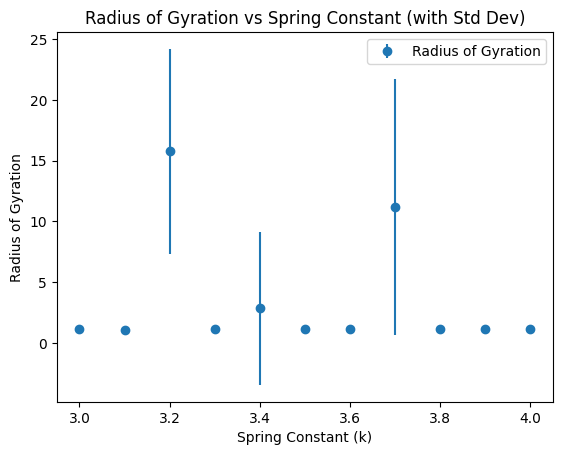

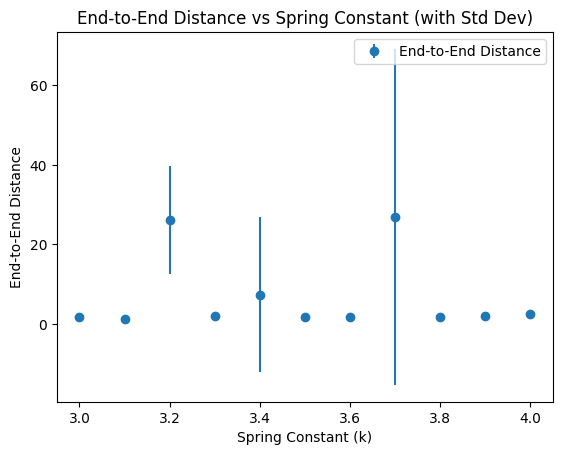

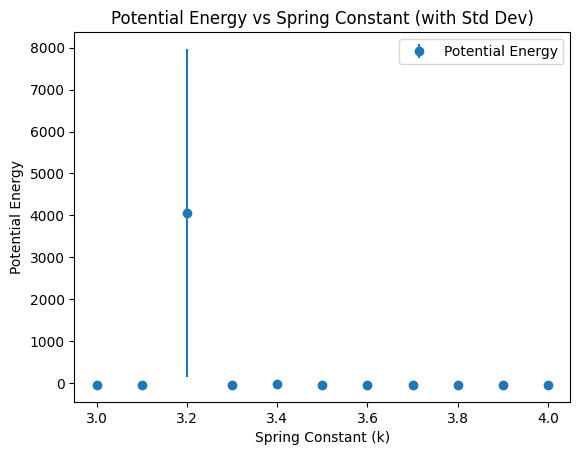

In [5]:
# Spring constant range for the simulation
k_values = np.linspace(3.0, 4.0, 11)

# Arrays to store results for different k values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each spring constant k
for k in k_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, k)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, k)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(len(positions) - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current k value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_k_{k:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for k = {k:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current k value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(k_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Spring Constant (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Spring Constant (k)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Spring Constant (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Spring Constant (with Std Dev)')
plt.legend()
plt.show()


In [6]:
# Print results for Radius of Gyration
print("Spring Constant (k) vs Radius of Gyration")
print(f"{'Spring Constant (k)':>20} {'Mean Rg':>10} {'Std Rg':>10}")
for k, mean_Rg, std_Rg in zip(k_values, mean_Rg_values, std_Rg_values):
    print(f"{k:20.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nSpring Constant (k) vs End-to-End Distance")
print(f"{'Spring Constant (k)':>20} {'Mean Ree':>10} {'Std Ree':>10}")
for k, mean_Ree, std_Ree in zip(k_values, mean_Ree_values, std_Ree_values):
    print(f"{k:20.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nSpring Constant (k) vs Potential Energy")
print(f"{'Spring Constant (k)':>20} {'Mean PE':>10} {'Std PE':>10}")
for k, mean_PE, std_PE in zip(k_values, mean_potential_energies, std_potential_energies):
    print(f"{k:20.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Spring Constant (k) vs Radius of Gyration
 Spring Constant (k)    Mean Rg     Std Rg
              3.0000     1.1249     0.0231
              3.1000     1.0937     0.0169
              3.2000    15.7708     8.4387
              3.3000     1.1399     0.0339
              3.4000     2.8446     6.3017
              3.5000     1.1410     0.0259
              3.6000     1.1668     0.0405
              3.7000    11.1982    10.5172
              3.8000     1.1594     0.0271
              3.9000     1.1747     0.0339
              4.0000     1.1781     0.0299

Spring Constant (k) vs End-to-End Distance
 Spring Constant (k)   Mean Ree    Std Ree
              3.0000     1.6149     0.4069
              3.1000     1.3072     0.3650
              3.2000    26.1461    13.5542
              3.3000     2.0762     0.4109
              3.4000     7.3470    19.5564
              3.5000     1.8144     0.5138
              3.6000     1.7788     0.5715
              3.7000    26.9027    42.2869
           

Trajectories for k = 4.00 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_4.00.npy
Trajectories for k = 4.10 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_4.10.npy
Trajectories for k = 4.20 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_4.20.npy
Trajectories for k = 4.30 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_4.30.npy
Trajectories for k = 4.40 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_4.40.npy
Trajectories for k = 4.50 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_4.50.npy
Trajectories for k = 4.60 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_4.60.npy
Trajectories for k = 4.70 saved to

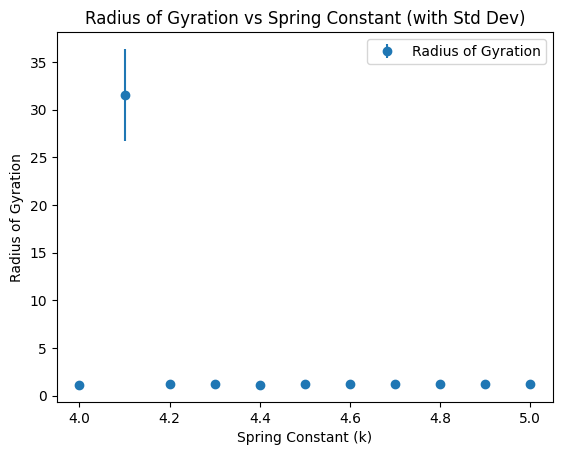

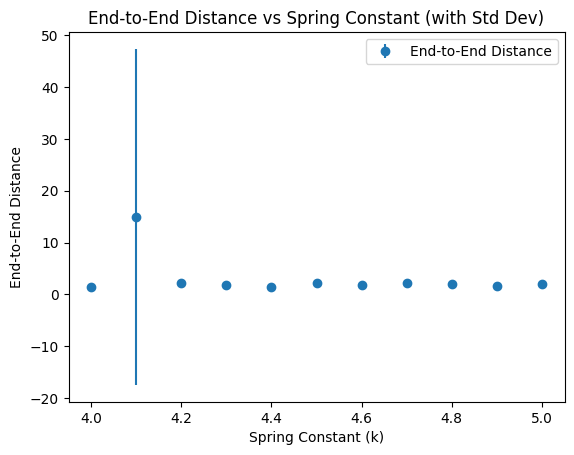

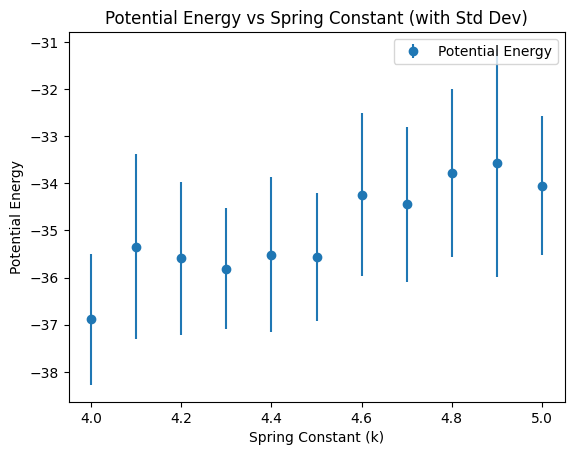

In [7]:
# Spring constant range for the simulation
k_values = np.linspace(4.0, 5.0, 11)

# Arrays to store results for different k values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each spring constant k
for k in k_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, k)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, k)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(len(positions) - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current k value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_k_{k:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for k = {k:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current k value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(k_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Spring Constant (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Spring Constant (k)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Spring Constant (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Spring Constant (with Std Dev)')
plt.legend()
plt.show()


In [8]:
# Print results for Radius of Gyration
print("Spring Constant (k) vs Radius of Gyration")
print(f"{'Spring Constant (k)':>20} {'Mean Rg':>10} {'Std Rg':>10}")
for k, mean_Rg, std_Rg in zip(k_values, mean_Rg_values, std_Rg_values):
    print(f"{k:20.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nSpring Constant (k) vs End-to-End Distance")
print(f"{'Spring Constant (k)':>20} {'Mean Ree':>10} {'Std Ree':>10}")
for k, mean_Ree, std_Ree in zip(k_values, mean_Ree_values, std_Ree_values):
    print(f"{k:20.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nSpring Constant (k) vs Potential Energy")
print(f"{'Spring Constant (k)':>20} {'Mean PE':>10} {'Std PE':>10}")
for k, mean_PE, std_PE in zip(k_values, mean_potential_energies, std_potential_energies):
    print(f"{k:20.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Spring Constant (k) vs Radius of Gyration
 Spring Constant (k)    Mean Rg     Std Rg
              4.0000     1.1554     0.0275
              4.1000    31.5361     4.8142
              4.2000     1.1784     0.0342
              4.3000     1.1761     0.0277
              4.4000     1.1656     0.0290
              4.5000     1.1726     0.0277
              4.6000     1.1993     0.0413
              4.7000     1.1967     0.0360
              4.8000     1.2053     0.0403
              4.9000     1.2056     0.0495
              5.0000     1.1895     0.0276

Spring Constant (k) vs End-to-End Distance
 Spring Constant (k)   Mean Ree    Std Ree
              4.0000     1.4385     0.3504
              4.1000    14.9421    32.4420
              4.2000     2.1893     0.6440
              4.3000     1.7521     0.5059
              4.4000     1.4846     0.3730
              4.5000     2.2432     0.4423
              4.6000     1.7195     0.4723
              4.7000     2.1976     0.4556
           

Trajectories for k 0.10 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_0.10.npy
Trajectories for k 0.20 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_0.20.npy
Trajectories for k 0.30 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_0.30.npy
Trajectories for k 0.40 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_0.40.npy
Trajectories for k 0.50 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_0.50.npy
Trajectories for k 0.60 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_0.60.npy
Trajectories for k 0.70 saved to: C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output\trajectories_k_0.70.npy
Trajectories for k 0.80 saved to: C:\Users\khh38

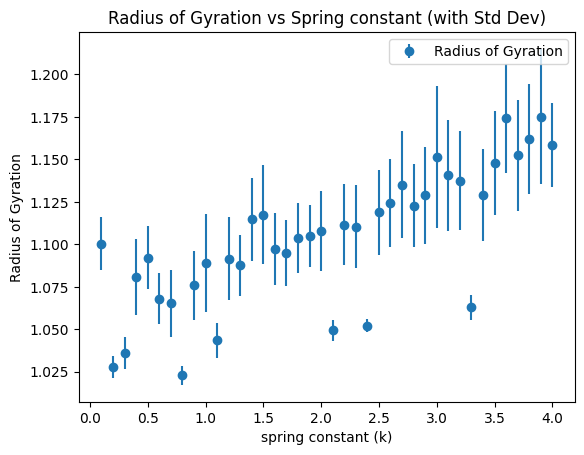

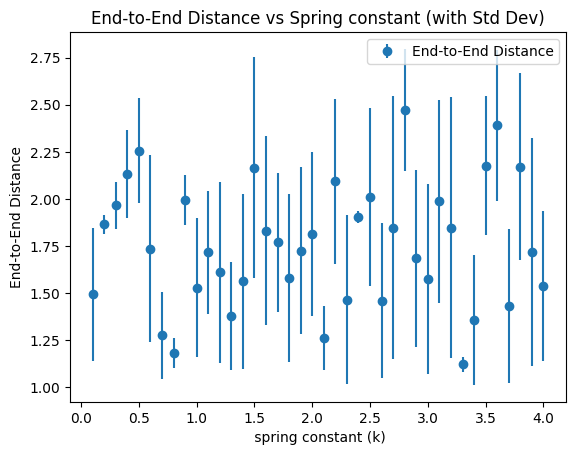

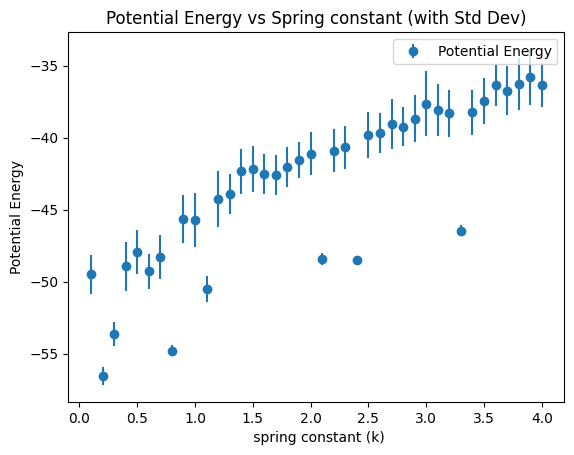

In [1]:
# 150000 stabilization
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
equilibration_steps = 140000  # Equilibration steps
sampling_steps = 10000  # Sampling steps
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.03 # Depth of repulsive LJ potential
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant
target_temperature = 0.1  # Target temperature

# Directory to store trajectories
output_dir = r"C:\Users\khh38\Desktop\PhD\Class\comp-prob-solv\Project_2\trajectories_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Initialize Positions and Velocities with ASE Atoms
def initialize_chain_ase(n_particles, box_size, r0):
    """Initialize polymer chain positions with ASE."""
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]

    # Create ASE Atoms object
    polymer_chain = Atoms(positions=positions, symbols='C' * n_particles, cell=[box_size, box_size, box_size], pbc=True)
    return polymer_chain

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        if distance != 0:
            force_magnitude = -k * (distance - r0)
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, box_size, epsilon_repulsive):
    forces = np.zeros_like(positions)
    for i in range(len(positions) - 1):
        for j in range(i + 1, len(positions)):
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff or distance == 0:
                continue  # Ignore interactions beyond the cutoff or zero distance
            if abs(i - j) == 2:
                epsilon_value = epsilon_repulsive
            elif abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
            force = force_magnitude * (displacement / distance)
            forces[i] -= force
            forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (len(velocities) * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# k range for the simulation
k_values = np.linspace(0.1, 4.0, 40)

# Arrays to store results for different epsilon values
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

# Loop over each k_values
for k in k_values:
    # Initialize positions and velocities with ASE
    polymer_chain = initialize_chain_ase(n_particles, box_size, r0)
    positions = polymer_chain.get_positions()
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size, epsilon_repulsive)

    # Equilibration phase
    for step in range(equilibration_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

    # Sampling phase
    Rg_values = []
    Ree_values = []
    potential_energies = []
    trajectories = []

    for step in range(sampling_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, box_size, epsilon_repulsive)
        polymer_chain.set_positions(positions)  # Update ASE positions
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Compute properties
        Rg = calculate_radius_of_gyration(positions)
        Ree = calculate_end_to_end_distance(positions)

        # Calculate potential energy
        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        E_LJ = 0.0
        for i in range(len(positions) - 1):
            for j in range(i + 1, len(positions)):
                displacement = positions[j] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                if distance < cutoff or distance == 0:
                    continue  # Ignore interactions beyond the cutoff or zero distance
                if abs(i - j) == 2:
                    epsilon_value = epsilon_repulsive
                elif abs(i - j) > 2:
                    epsilon_value = epsilon_attractive
                else:
                    continue
                E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

        potential_energy = E_harmonic + E_LJ

        # Store results
        Rg_values.append(Rg)
        Ree_values.append(Ree)
        potential_energies.append(potential_energy)
        trajectories.append(positions.copy())

    # Convert lists to NumPy arrays
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)
    trajectories = np.array(trajectories)

    # Save the trajectory data for the current epsilon value
    trajectory_file_path = os.path.join(output_dir, f"trajectories_k_{k:.2f}.npy")
    np.save(trajectory_file_path, trajectories)
    print(f"Trajectories for k {k:.2f} saved to: {trajectory_file_path}")

    # Calculate mean and standard deviation for the current epsilon value
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with standard deviation
plt.figure()
plt.errorbar(k_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('spring constant (k)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Spring constant (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel(' spring constant (k)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Spring constant (with Std Dev)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel(' spring constant (k)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Spring constant (with Std Dev)')
plt.legend()
plt.show()




In [2]:
# Print results for Radius of Gyration
print("Spring Constant (k) vs Radius of Gyration")
print(f"{'Spring Constant (k)':>20} {'Mean Rg':>10} {'Std Rg':>10}")
for k, mean_Rg, std_Rg in zip(k_values, mean_Rg_values, std_Rg_values):
    print(f"{k:20.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nSpring Constant (k) vs End-to-End Distance")
print(f"{'Spring Constant (k)':>20} {'Mean Ree':>10} {'Std Ree':>10}")
for k, mean_Ree, std_Ree in zip(k_values, mean_Ree_values, std_Ree_values):
    print(f"{k:20.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nSpring Constant (k) vs Potential Energy")
print(f"{'Spring Constant (k)':>20} {'Mean PE':>10} {'Std PE':>10}")
for k, mean_PE, std_PE in zip(k_values, mean_potential_energies, std_potential_energies):
    print(f"{k:20.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Spring Constant (k) vs Radius of Gyration
 Spring Constant (k)    Mean Rg     Std Rg
              0.1000     1.1002     0.0156
              0.2000     1.0276     0.0064
              0.3000     1.0362     0.0095
              0.4000     1.0810     0.0224
              0.5000     1.0921     0.0185
              0.6000     1.0680     0.0149
              0.7000     1.0653     0.0197
              0.8000     1.0228     0.0055
              0.9000     1.0758     0.0200
              1.0000     1.0891     0.0286
              1.1000     1.0436     0.0103
              1.2000     1.0916     0.0245
              1.3000     1.0876     0.0179
              1.4000     1.1146     0.0242
              1.5000     1.1175     0.0293
              1.6000     1.0970     0.0212
              1.7000     1.0949     0.0196
              1.8000     1.1034     0.0206
              1.9000     1.1047     0.0182
              2.0000     1.1076     0.0236
              2.1000     1.0495     0.0062
            